In [1]:
import numpy as np
import matplotlib.pyplot as plt


from scipy.fftpack import fft
from scipy.fftpack import fftfreq
from scipy.signal import find_peaks,findfreqs,spectrogram
import scipy.optimize 
import pandas as pd
from pyexcel_ods import get_data

In [2]:
ods=get_data('analisis_motores.ods')

In [3]:
df1=pd.DataFrame(ods['real001'][1:],columns=ods['real001'][0])
df2=pd.DataFrame(ods['real002'][1:],columns=ods['real002'][0])

In [4]:
df1.head()

,n,i,ain0,ain1,ain2,ain4,ain5,ain6
0,2,0,2715,-1955,-858,2665,11599,-14644
1,3,1,3009,-1328,-1847,-2286,14094,-12401
2,4,2,2935,-552,-2616,-6828,14857,-8551
3,5,3,2535,171,-2948,-10590,14345,-4218
4,6,4,1854,1074,-3219,-13642,12599,667


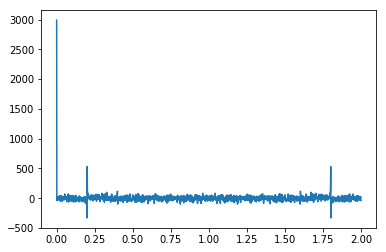

In [39]:
N=2000
T=1./1000
x=np.linspace(0.,N*T,N)

f1=df1['ain0'].values*np.sin(df1['ain4'])*np.pi*2.0*x
f2=df1['ain0'].values*df1['ain4']*np.pi*2.0*x
f3=df1['ain2'].values*df1['ain6']*np.pi*2.0*x
f1f=fft(abs(f1))


fig, ax = plt.subplots()
# plt.axis([0,2000,0,120])
ax.plot(x,2.0/10000 *f1f)
# ax.plot(x,f2)
# ax.plot(x,f3)

plt.show()

In [41]:
MAX1_A= max(np.abs(f1f))*2.0/N  #maximos absoluto debido a que es un N complejo
picks_f1f=find_peaks( 2.0/N*np.abs(f1f),height=MAX1_A/50 )
# frecuencia y picos
L1_A=int(len(picks_f1f[0])/2)
picos_f1f=np.zeros((L1_A,N))
#################################
picos_f1f[:,0] = x[picks_f1f[0][0:L1_A]]
picos_f1f[:,1]= picks_f1f[1]['peak_heights'][0:L1_A]
# Para poder usar las fft, hay que trabajar con los INDICES donde concuerda la frecuencia en este caso, el 40
picks_f1f  , picos_f1f   #  ESTO ES INFORMACION DE SALIDA 

((array([   8,   12,   14,   18,   20,   22,   27,   30,   33,   35,   48,
           53,   57,   61,   67,   77,   81,   97,  102,  108,  121,  126,
          129,  146,  165,  183,  186,  195,  200,  205,  228,  231,  248,
          256,  261,  265,  277,  283,  297,  299,  302,  306,  312,  319,
          327,  329,  355,  361,  365,  371,  373,  388,  400,  404,  411,
          423,  437,  441,  456,  462,  466,  472,  480,  486,  499,  514,
          516,  518,  520,  522,  529,  533,  536,  538,  550,  555,  557,
          559,  573,  600,  615,  634,  641,  648,  654,  657,  661,  666,
          674,  688,  699,  702,  725,  728,  733,  749,  759,  786,  790,
          792,  809,  812,  816,  835,  841,  856,  862,  876,  882,  891,
          897,  899,  904,  908,  915,  918,  921,  923,  925,  930,  943,
          946,  948,  959,  983,  989, 1011, 1017, 1041, 1052, 1054, 1057,
         1070, 1075, 1077, 1079, 1082, 1085, 1092, 1096, 1101, 1103, 1109,
         1118, 1124, 1138

In [42]:
RPM_nom = 3200  #DATO CHAPA 
Vel_angular_nom = RPM_nom*2*np.pi/60
s_nom=4/100 #DATO CHAPA   # me armo una función de resbalamiento para el transitorio de arranque, no uso F(k*s), sólo en los cálculos
s_arr=.999

def s(x):
    if x<0.5:
        s=4*(s_nom-s_arr)*x**2 +s_arr 
    else:
        if x>=0.5:
            s=s_nom 
    return s

# ACLARACION s es la velocidad de deslizamiento

In [43]:
s_motor=[s(x[e]) for e in range(N)]
# armo una impedancia equivalente del motor para probar resto del código, NO TRABAJAR CON ÁNGULO, TRABAJAR CON RADIANES
R1mot=R2mot= 6 # original 6 , prueba con 1                # FUNCION np.degrees() tiene mucho error al pasar rad a deg y los cos y sin no dan bien
X1mot=X2mot= 13j  #original 13 , prueba con 5j
Z1mot=R1mot+X1mot 
# Z2mot=R2mot+X2mot tengo que ponerle el resbalamiento
Z0mot=35+6.5j  #  original = 35+6.5j ,  prueba con  55+6j

Zmotor_test=[Z1mot +Z0mot*(R2mot/s_motor[e]+X2mot)/(Z0mot +R2mot/s_motor[e]+X2mot) for e in range(N)] 

In [44]:

def funcion_de_onda(corriente,tension):
    I1_A=[(corriente/abs(Zmotor_test[i]))*np.sin( tension*x[i] -np.angle(Zmotor_test[i]))  for i in range(N)]
    return I1_A

In [49]:
asd=funcion_de_onda(df1['ain0'],df1['ain4'])
asd1=funcion_de_onda(df1['ain1'],df1['ain5'])
asd2=funcion_de_onda(df1['ain2'],df1['ain6'])

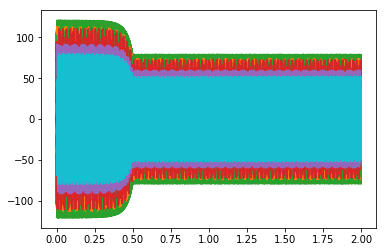

In [68]:
fig, ax = plt.subplots()
ax.plot(x,asd)

plt.show()

In [38]:
def n_componentes(onda,escalada=True):
    if not escalada:
        
        transformada_fourier=fft(np.abs(onda))
    else:
        transformada_fourier=(2./N)*fft(np.abs(onda))
    return transformada_fourier

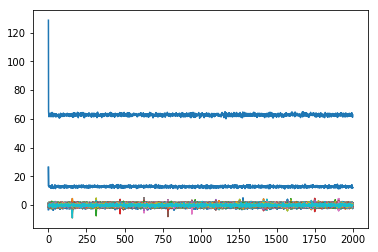

In [15]:
fig, ax = plt.subplots()
ax.plot(x,n_componentes(funcion_de_onda(df1['ain0'],df1['ain4']),escalada=True))

plt.show()

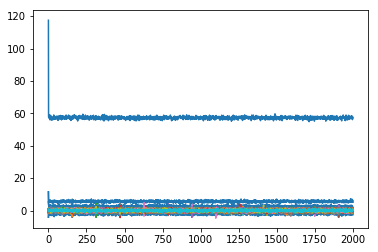

In [16]:
fig, ax = plt.subplots()
ax.plot(x,n_componentes(funcion_de_onda(df1['ain1'],df1['ain5']),escalada=True))

plt.show()

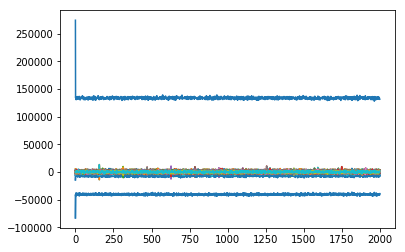

In [17]:
fig, ax = plt.subplots()
ax.plot(x,fft(fft(n_componentes(funcion_de_onda(df1['ain2'],df1['ain6']),escalada=True))))
plt.show()

In [18]:
asa=n_componentes(funcion_de_onda(df1['ain2'],df1['ain6']),escalada=True)

In [19]:
f, t, Sxx =spectrogram(asa,N)

/home/martin/anaconda/lib/python3.7/site-packages/scipy/signal/spectral.py:1819: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


In [20]:
I1_C=[(df1['ain0']/abs(Zmotor_test[i]))*np.sin( df1['ain4']*x[i] -np.angle(Zmotor_test[i]) -np.pi*2/3 )  for i in range(N)]

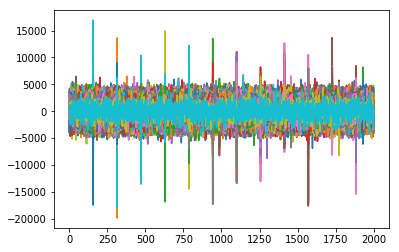

In [21]:
fig, ax = plt.subplots()
ax.plot(x,fft(I1_C))
plt.show()

In [1]:
# supuestamente con enventanado

from scipy.fftpack import fft
# Number of sample points
N = 2000
# sample spacing
T = 1.0 / 1000.0
x = np.linspace(0.0, N*T, N)
yf = fft(y)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(y*w)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

NameError: name 'np' is not defined